# Table of contents

# Introduction
Assignment 3 of the course CSE 5334 - Data Mining for Spring 2020 semester. Please use this [link](https://github.com/harsha993/sa-nb-review) to download this project as a package

# Dataset
The dataset contains 25000 text files containing positive movie reviews and 25000 text files containing negative movie reviews for training and the same volume of files for testing. 

## Necessary imports
The core of the algorithm i.e. the calculation of probabilites are done without using any libraries. However, to simplify loading of data, shuffling, plotting graphs and to cleanup the data, the following libraries are used

In [132]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import random
import nltk # Used only to lemmatize certain words
from pprint import pprint
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
import numpy as np # Used for np.NaN
from IPython.display import display, HTML
import collections
import seaborn as sn
import statistics

# Setting width of the notebook to 85% of screen width
display(HTML(data="""
<style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
</style>
"""))

%matplotlib inline
nltk.download('wordnet',quiet=True)
lmtzr = WordNetLemmatizer()

## Load the dataset
The data is loaded by iteratively loading each file and appending the contents of the file into a dataframe. To reduce the amount of time the notebook takes to load the data, the data once properly loaded is `pickled` with `gzip` compression so that from the next time the notebook is run, the data is loaded much faster. 

In [133]:
def load(path, kind):
    pickle_path = '{}/{}_processed.pkl'.format(path, kind)
    if os.path.exists(pickle_path):
        return pd.read_pickle(pickle_path, compression='gzip')
    
    df = pd.DataFrame(columns=['_document','_data','_class'])
    
    for root, dirname, files in os.walk('{}/{}/neg'.format(path,kind)):
        files = [os.path.join(root,fname) for fname in files]
        for file in files:
            with open(file, 'rt') as f:
                df = df.append({'_document':file,'_data':f.read(), '_class':'neg'}, ignore_index=True)

        for root, dirname, files in os.walk('{}/{}/pos'.format(path,kind)):
            files = [os.path.join(root,fname) for fname in files]
            for file in files:
                with open(file, 'rt') as f:
                    df = df.append({'_document': file,'_data':f.read(), '_class':'pos'}, ignore_index=True)
    df.to_pickle(pickle_path, compression='gzip')
    return df

In [134]:
df = load('data/aclImdb','train')
df = df.sample(frac=1.0)

# Data Preprocessing/Cleanup
Before implementing the model, it is important to cleanup the records as this dataset contains special characters, HTML tags, quoted and hyphenated words, etc.

## Remove punctuation
The following method used python's regular expressions library `re` to remove
1. Punctuation
2. HTML Tags
3. Special Characters

In [135]:
def remove_punctuation(document):
    document = document.lower()
    document = re.sub('</*\s*\w+\s*/*>', '', document)
    document = re.sub('\W+',' ',document)
    document = re.sub('\s+',' ', document)
    return document.split(' ')

## Remove Stopwords
Even after the initial cleanup of removing unwanted special characters and tags, the dataset contains some of the most commonly occurring words in english such as articles (a,the) which don't contribute much useful information for the model. Therefore we eliminiate such words. Here's a list of most commonly occurring words in english sentences sourced from this [gist](https://gist.github.com/sebleier/554280)

This method removes such stopwords from a document

In [136]:
stopwords = ["a","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
             "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
             "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
             "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
             "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
             "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
             "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", 
             "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
             "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
             "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def remove_stopwords(document):
    return list(filter(lambda word: word not in stopwords, document))
    

## Omit rare words
In order to prevent bias caused by very rarely occurring words i.e. those that appear less than five times across the whole dataset, we remove such words from our corpus using the following method

In [137]:
def omit_rare_words(document, vocab):
    document = set(document).intersection(vocab)
    document.discard('')
    return document

## Lemmatize words
Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. For example, in English, the verb 'to walk' may appear as 'walk', 'walked', 'walks' or 'walking'. The base form, 'walk', that one might look up in a dictionary, is called the lemma for the word. 

To refine quality and quantity of the information we can extract from our documents, we lemmatize all the words in our documents using `nltk`'s library

In [138]:
def lemmatize(document):
    return [lmtzr.lemmatize(word) for word in document]

In [139]:
df['_data'] = df['_data'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize)
print(df.shape)
df.head()

(25000, 3)


,_document,_data,_class
8318,data/aclImdb/train/neg/8768_4.txt,"[please, start, calling, name, like, unpatriot...",neg
12615,data/aclImdb/train/pos/5443_8.txt,"[pretty, good, movie, like, john, stamos, full...",pos
1988,data/aclImdb/train/neg/12085_3.txt,"[really, much, need, begin, little, review, pl...",neg
16042,data/aclImdb/train/pos/3945_10.txt,"[rating, 5, movie, could, used, better, acting...",pos
12398,data/aclImdb/train/neg/11325_4.txt,"[ravaged, wasteland, future, mankind, terroriz...",neg


In [140]:
pos = df[df['_class']=='pos']['_data'].apply(lambda x: ' '.join(x)).values
neg = df[df['_class']=='neg']['_data'].apply(lambda x: ' '.join(x)).values

## Basic EDA
The documents in the dataset are equally distributed between positive and negative reviews with about 25000 files for each review. 

### Most occurring words
Here are some of the most occurring words in each type of reviews

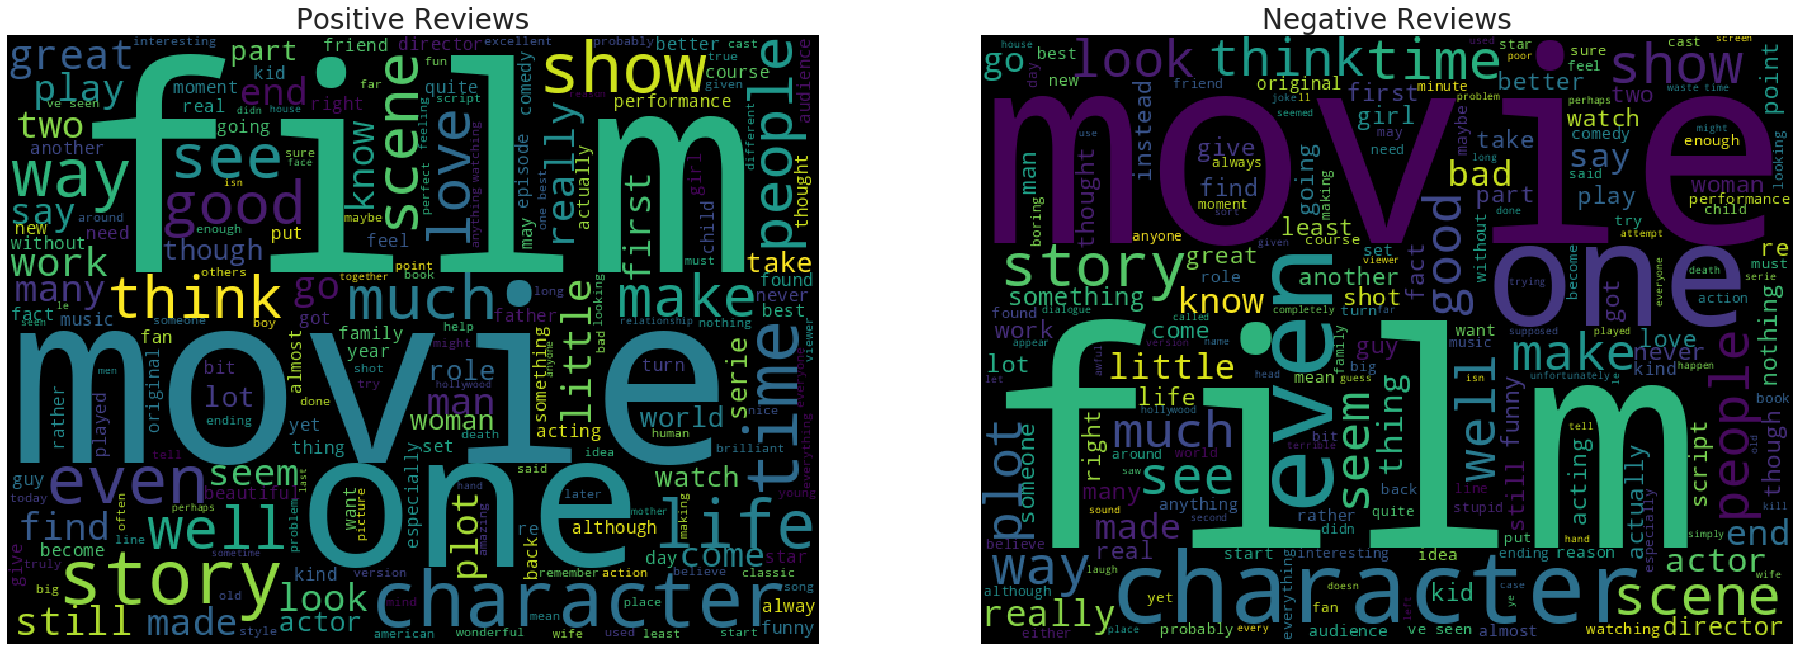

In [141]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[32,18])
cloud1 = WordCloud(background_color='black',width=640,height=480).generate(' '.join(pos))
cloud2 = WordCloud(background_color='black', width=640,height=480).generate(' '.join(neg))

ax1.imshow(cloud1)
ax1.axis('off')
ax1.set_title('Positive Reviews', fontsize=28)

ax2.imshow(cloud2)
ax2.axis('off')
ax2.set_title('Negative Reviews', fontsize=28)
plt.show()

# Implementation
## Naive Bayes Algorithm

Naïve Bayes Classifier uses following formula to make a prediction:
![](./img/nb-formula.png)
## Drawback of Naive Bayes
Sometimes certain words that aren't in the train set can appear in the test set. In these situations, the posterior probability of such a document would become be thrown off because conditional probablity of that word is zero. 

## Smoothing
To overcome this unfavorable condition, smoothing techniques are used. One of the most popular smoothing techniques for Naive Bayes is the Laplace smoothing
### Laplace Smoothing
In Laplace Smoothing, we slightly tweak conditional probability of each word using the following formula

    P(word|class='Positive') = (number of Positive documents containing the word + 1) / (Total number positive documents + Total unique words in corpus)
    P(word|class='Negative') = (number of Negative documents containing the word + 1) / (Total number positive documents + Total unique words in corpus)

This way, none of the conditional probability is zero, as a result the posterior probability is not thrown off balance. 

## Five fold cross-validation
In order to better understand hyper-parameters and tune them, we perform k fold cross-validation. In this case, we perform 5 fold cross validation in the following steps
1. Shuffle the dataset
2. Divide the dataset into five equal parts
3. Consider each part as dev set and the remaining data as train set
4. Build a vocabulary of words present in the train set
5. For each word in this vocabulary, count the number of occurrences in positive and negative reviews
6. Calculate conditional and posterior probabilies **without smoothing** for all documents
7. Elect the class with highest probability as the class of the current document
8. Apply ***Laplace Smoothing*** over the train set to account for zero probabilities
9. Calculate accuracies and repeat step 3 through 9 five times


### Determine class
This method elects the class with highest posterior probability and accordingly classifies a document as either positive or negative

In [142]:
def determine_class(row, smooth=False):
    pos_col, neg_col = '_pos', '_neg'
    if smooth:
        pos_col , neg_col = '_pos_smooth', '_neg_smooth'
    if row[pos_col] == 0 and row[neg_col] == 0:
        return np.NAN
    if row[pos_col] >= row[neg_col]:
        return 'pos'
    else:
        return 'neg'

### Calculate Conditional probability
Conditional probability of a word is calculated using the formula
    
    P(word|class='Positive') = (number of Positive documents containing the word) / (Total number positive documents)
    P(word|class='Negative') = (number of Negative documents containing the word) / (Total number positive documents)

In [143]:
def get_conditional(word, sentiment, smooth):
        if smooth:
            if word not in word_counts:
                wc = 0
            else:
                wc = word_counts[word][sentiment]
            return wc+1/(num_sentiment[sentiment]+len(vocabulary['train']))
        if word not in word_counts:
            return 0
        return word_counts[word][sentiment]/num_sentiment[sentiment]

### Calculate Posterior probability
Posterior probability of document belonging to a certain class is calculated using the formula

    P(class='Pos'| words in document) = P(doc='Pos') * {P(word[1]|class='Pos') * P(word[2]|class='pos') ... * P(word[n]|class='pos')}
    P(class='Neg'| words in document) = P(doc='Neg') * {P(word[1]|class='Neg') * P(word[2]|class='Neg') ... * P(word[n]|class='Neg')}
    
    
Where,
    
    P(class='Pos') , P(class='Neg') are called Prior Probabilities and are calculated using
    
    P(class='Pos') = (Number of Positive reviews)/Total number of reviews
    P(class='Neg') = (Number of Negative reviews)/Total number of reviews
    
    

In [144]:
def get_posterior(document, sentiment, corpus, smooth=False):
    p = num_sentiment[sentiment]/corpus.shape[0]
    for word in document:
        p *= get_conditional(word, sentiment, smooth)
    return p

### Prepare vocabulary
Inorder to calculate Prior, Conditional and Posterior probabilites, it is helpful to memoize certain calculations to avoid redundant calculation which takes a lot of time.

The following actions are performed and results are stored in a dictionary for **every iteration** in the five-fold validation
1. A vocabulary of unique words in train set is constructed
2. For each word in the vocabulary, the following counts are calculated. 
    * Number of occurrences of the word in positive reviews
    * Number of occurrences of the word in negative reviews

In [145]:
def prepare_vocab(df, dataset):
    wc = []
    df['_data'].apply(lambda data: wc.extend(data))
    wc = dict(collections.Counter(wc))
    print('Distinct words in {}: {}'.format(dataset, len(wc.keys())))
    wc = [ k for k,v in wc.items() if v>5 ]
    print('Distinct words in {} after removing rare words: {}'.format(dataset, len(wc)))
    return wc

## Apply five fold cross-validation
Using the functions written above, five-fold cross validation is performed on the dev set with and without Laplace smoothing and respective accuracies are recorded. Accuracies of positive reviews, negative reviews and overall accuracy are summarized as a Confusion Matrix in the subsequent plots

Pass#1
Distinct words in Train Set: 61931
Distinct words in Train Set after removing rare words: 21249
Distinct words in Dev Set: 35122
Distinct words in Dev Set after removing rare words: 10202


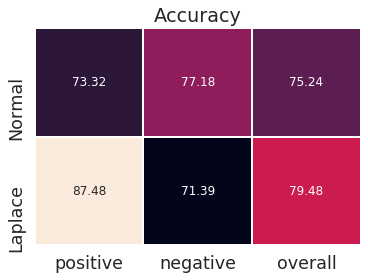

Pass#2
Distinct words in Train Set: 62182
Distinct words in Train Set after removing rare words: 21319
Distinct words in Dev Set: 34538
Distinct words in Dev Set after removing rare words: 9989


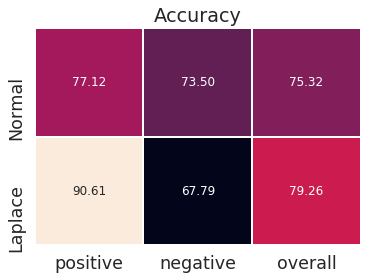

Pass#3
Distinct words in Train Set: 62216
Distinct words in Train Set after removing rare words: 21371
Distinct words in Dev Set: 34458
Distinct words in Dev Set after removing rare words: 10011


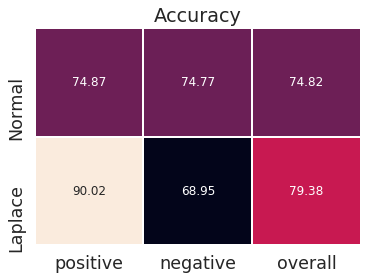

Pass#4
Distinct words in Train Set: 62328
Distinct words in Train Set after removing rare words: 21379
Distinct words in Dev Set: 34012
Distinct words in Dev Set after removing rare words: 9960


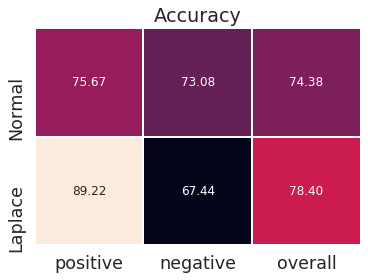

Pass#5
Distinct words in Train Set: 62023
Distinct words in Train Set after removing rare words: 21320
Distinct words in Dev Set: 34838
Distinct words in Dev Set after removing rare words: 10037


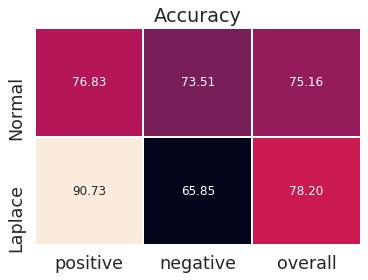

In [146]:
accuracy = {'normal':{'pos':[], 'neg':[], 'overall':[]}, 'smooth': {'pos':[], 'neg':[], 'overall':[]}}
confusion_matrix = [[0]*3]*2 
chunk_size = df.shape[0]//5
for i in range(5):
    print("Pass#{}".format(i+1))
    dev_start = i*chunk_size
    dev_end = dev_start + chunk_size
    vocabulary = {}
    word_counts = {}
    num_sentiment = {}
    
    dev_df = df[dev_start:dev_end].copy()
    train_df = pd.concat([df[0:dev_start], df[dev_end:df.shape[0]]])
    
    vocabulary['train'] = prepare_vocab(train_df, 'Train Set')
    train_df['_data'] = train_df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['train']))

    vocabulary['dev'] = prepare_vocab(dev_df, 'Dev Set')
    dev_df['_data'] = dev_df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['dev']))
    
    num_sentiment['pos'] = train_df[train_df['_class']=='pos'].shape[0]
    num_sentiment['neg'] = train_df[train_df['_class']=='neg'].shape[0]
    
    for word in vocabulary['train']:
        docs_with_word = train_df[train_df['_data'].map(set([word]).issubset)]
        pos_docs_with_word = docs_with_word[docs_with_word['_class']=='pos'].shape[0]
        neg_docs_with_word = docs_with_word[docs_with_word['_class']=='neg'].shape[0]
        word_counts[word] = {'pos': pos_docs_with_word, 'neg': neg_docs_with_word}
    
    dev_df['_pos'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'pos', train_df))
    dev_df['_neg'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'neg', train_df))
    dev_df['_predicted_class'] = dev_df.apply(determine_class,axis=1)
    
    dev_df['_pos_smooth'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'pos', train_df, True))
    dev_df['_neg_smooth'] = dev_df['_data'].apply(lambda doc: get_posterior(doc, 'neg', train_df, True))
    dev_df['_predicted_class_smooth'] = dev_df.apply(lambda row: determine_class(row,smooth=True),axis=1)
    
    pos_acc = dev_df[(dev_df['_class']==dev_df['_predicted_class'])
                    & (dev_df['_class']=='pos')].shape[0]*100/dev_df[dev_df['_class']=='pos'].shape[0]
    neg_acc = dev_df[(dev_df['_class']==dev_df['_predicted_class'])
                    & (dev_df['_class']=='neg')].shape[0]*100/dev_df[dev_df['_class']=='neg'].shape[0]
    
    pos_acc_sm = dev_df[(dev_df['_class']==dev_df['_predicted_class_smooth'])
                    & (dev_df['_class']=='pos')].shape[0]*100/dev_df[dev_df['_class']=='pos'].shape[0]
    neg_acc_sm = dev_df[(dev_df['_class']==dev_df['_predicted_class_smooth'])
                    & (dev_df['_class']=='neg')].shape[0]*100/dev_df[dev_df['_class']=='neg'].shape[0]
    
    acc = dev_df[dev_df['_class']==dev_df['_predicted_class']].shape[0]*100/dev_df.shape[0]
    acc_smooth = dev_df[dev_df['_class']==dev_df['_predicted_class_smooth']].shape[0]*100/dev_df.shape[0]
    
    accuracy['normal']['pos'].append(pos_acc)
    accuracy['normal']['neg'].append(neg_acc)
    accuracy['normal']['overall'].append(acc)
    accuracy['smooth']['pos'].append(pos_acc_sm)
    accuracy['smooth']['neg'].append(neg_acc_sm)
    accuracy['smooth']['overall'].append(acc_smooth)
    
    confusion_matrix[0] = [pos_acc, neg_acc, acc]
    confusion_matrix[1] = [pos_acc_sm, neg_acc_sm, acc_smooth]
    
    cfdf = pd.DataFrame(confusion_matrix, columns=['positive', 'negative', 'overall'], index=['Normal','Laplace'])
    sn.set(font_scale=1.6) # for label size
    sn.heatmap(cfdf, annot=True, annot_kws={"size": 12}, fmt='.2f',
           linewidths=1, cbar=False, square=True).set_title("Accuracy")
    plt.show()
    plt.close()

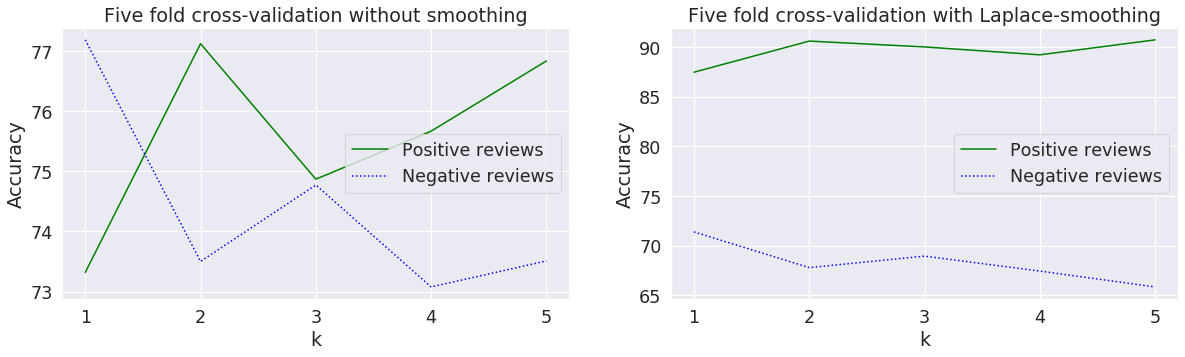

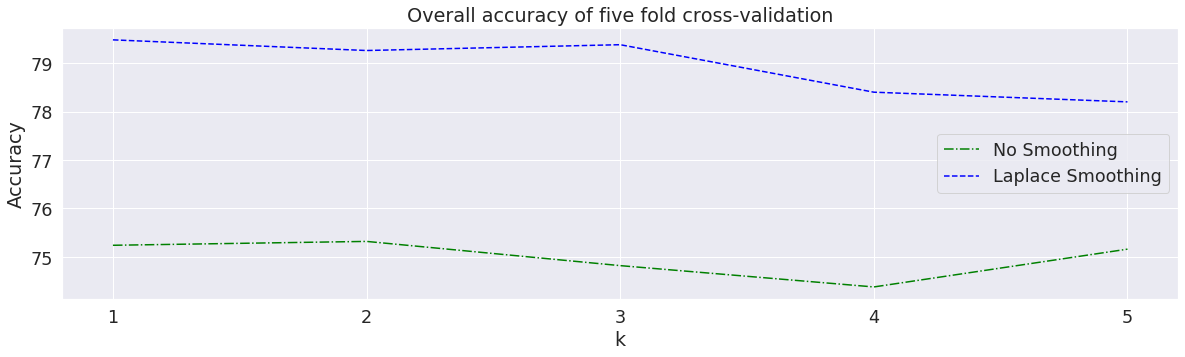

In [147]:
k = [1,2,3,4,5]
fig, (ax1,ax2)  = plt.subplots(1,2, figsize=[20,5])
ax1.plot(k, accuracy['normal']['pos'], label="Positive reviews", color="green")
ax1.plot(k, accuracy['normal']['neg'], label="Negative reviews", color="blue", linestyle=':')
# ax1.plot(k, accuracy['normal']['overall'], label="Overall", color="orange", linestyle='--')
ax1.set_xlabel("k")
ax1.set_title("Five fold cross-validation without smoothing")
ax1.set_ylabel("Accuracy")
ax1.set_xticks(k)
ax1.legend(loc='best')

ax2.plot(k, accuracy['smooth']['pos'], label="Positive reviews", color="green")
ax2.plot(k, accuracy['smooth']['neg'], label="Negative reviews", color="blue", linestyle=':')
# ax2.plot(k, accuracy['smooth']['overall'], label="Overall", color="orange", linestyle='--')
ax2.set_xlabel("k")
ax2.set_title("Five fold cross-validation with Laplace-smoothing")
ax2.set_ylabel("Accuracy")
ax2.set_xticks(k)
ax2.legend(loc='best')

fig, ax  = plt.subplots(1,1, figsize=[20,5])
ax.plot(k, accuracy['normal']['overall'], label="No Smoothing", color="green", linestyle='-.')
ax.plot(k, accuracy['smooth']['overall'], label="Laplace Smoothing", color="blue", linestyle='--')
ax.set_xlabel("k")
ax.set_title("Overall accuracy of five fold cross-validation")
ax.set_ylabel("Accuracy")
ax.set_xticks(k)
ax.legend(loc='best')

plt.show()
plt.close()

> As it can be observed from the above plots, laplace smoothing improved accuracy of prediction for positive documents but made it worse for negative documents. However, the overall accuracy improved with smoothing.

## Top 10 Positive and Negative words
After observing accuracies of no-smoothing vs Laplace Smoothing on the dataset, let's observe the top 10 words that  predicted positive and negative reviews respectively

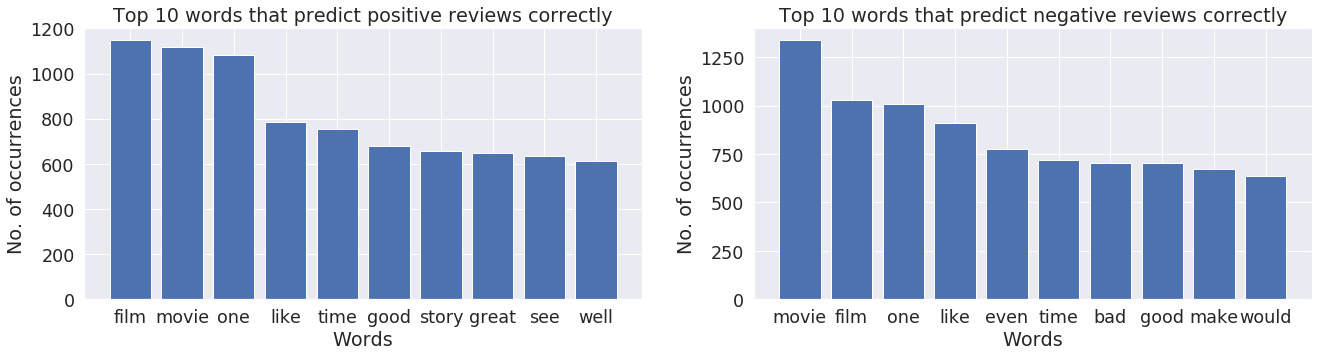

In [148]:
pos_words = []
neg_words = []

dev_df[(dev_df['_class']=='pos') 
       & (dev_df['_class']==dev_df['_predicted_class'])
      ]['_data'].apply(pos_words.extend)
pos_words = collections.Counter(pos_words).most_common(10)

dev_df[(dev_df['_class']=='neg') 
       & (dev_df['_class']==dev_df['_predicted_class'])
      ]['_data'].apply(neg_words.extend)
neg_words = collections.Counter(neg_words).most_common(10)

nw = [w for w,c in neg_words]
nc = [c for w,c in neg_words]

pw = [w for w,c in pos_words]
pc = [c for w,c in pos_words]

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=[22,5])
ax1.bar(pw, height=pc)
ax1.set_title("Top 10 words that predict positive reviews correctly")
ax1.set_ylabel("No. of occurrences")
ax1.set_xlabel("Words")

ax2.bar(nw, height=nc)
ax2.set_title("Top 10 words that predict negative reviews correctly")
ax2.set_ylabel("No. of occurrences")
ax2.set_xlabel("Words")
plt.show()

# Apply Naive Bayes on Test Set

As it can be noticed from the accuracy plots, applyint Laplace smoothing improved the overall accuracy. Hence we will be appling the same to out test set. This time, all the records in the train folder are considered as train data and all the records in the test folder are considered as test data. 

Similar to train data, basic cleanup is performed on the test data as well. 

In [149]:
test_df = load('data/aclImdb','test')

## Clean Test Data

Using the functions defined above, the test dataset is cleaned up by performing the following
1. Remove punctuations
2. Remove stopwords
3. Lemmatize words
4. Eliminate rare words

In [150]:
test_df['_data'] = test_df['_data'].apply(remove_punctuation).apply(remove_stopwords).apply(lemmatize)
vocabulary['test'] = prepare_vocab(test_df, 'Test Set')
vocabulary['train'] = prepare_vocab(df, 'Train Set for final prediction')
df['_data'] = df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['train']))
test_df['_data'] = test_df['_data'].apply(lambda doc: omit_rare_words(doc,vocabulary['test']))
test_df.head()

Distinct words in Test Set: 67336
Distinct words in Test Set after removing rare words: 23216
Distinct words in Train Set for final prediction: 68212
Distinct words in Train Set for final prediction after removing rare words: 23698


,_document,_data,_class
0,data/aclImdb/test/neg/929_2.txt,"{production, computer, rather, film, try, like...",neg
1,data/aclImdb/test/neg/995_1.txt,"{bear, including, perhaps, ended, french, plen...",neg
2,data/aclImdb/test/neg/8544_4.txt,"{skimpy, fierce, obnoxious, geographic, named,...",neg
3,data/aclImdb/test/neg/5691_1.txt,"{never, fast, aw, blurry, word, won, protagoni...",neg
4,data/aclImdb/test/neg/11771_1.txt,"{tho, minute, rest, big, nerd, anyway, 2, heck...",neg


## Build Vocabulary
Since we are considering all the files in the train folder, we build vocabulary and calculate the word counts once again

In [151]:
word_counts = {}
num_sentiment = {}

num_sentiment['pos'] = df[df['_class']=='pos'].shape[0]
num_sentiment['neg'] = df[df['_class']=='neg'].shape[0]

for word in vocabulary['train']:
    docs_with_word = df[df['_data'].map(set([word]).issubset)]
    pos_docs_with_word = docs_with_word[docs_with_word['_class']=='pos'].shape[0]
    neg_docs_with_word = docs_with_word[docs_with_word['_class']=='neg'].shape[0]
    word_counts[word] = {'pos': pos_docs_with_word, 'neg': neg_docs_with_word}

## Apply Naive Bayes with Laplace-Smoothing on test set

Smoothing is applied while calculating the posterior probability in the function `get_posterior()` by passing the 4th argument (smooth) as True. 

Using the methods defined above, we apply the Naive Bayes algorithm over the test dataset utilizing the entire train set, predict class and calculate accuracy for Positive reviews, negative reviews and overall accuracy

In [152]:
test_df['_pos'] = test_df['_data'].apply(lambda doc: get_posterior(doc, 'pos', df, True))
test_df['_neg'] = test_df['_data'].apply(lambda doc: get_posterior(doc, 'neg', df, True))
test_df['_predicted_class'] = test_df.apply(determine_class,axis=1)

## Accuracy over test data

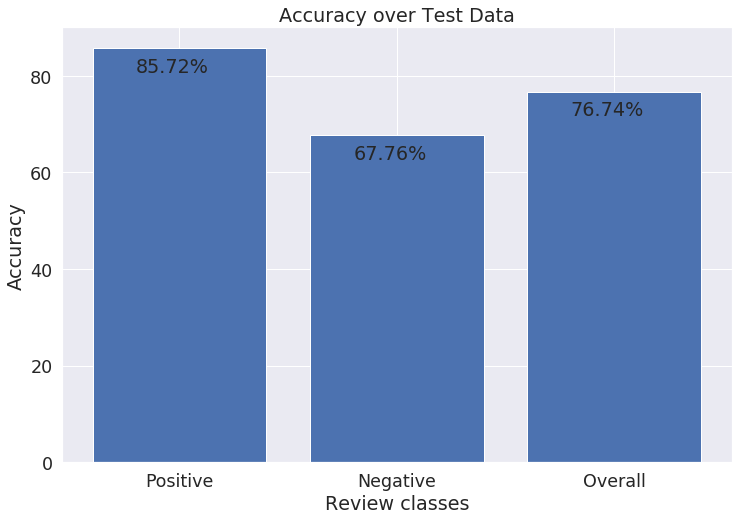

In [153]:
correct_predictions = test_df[test_df['_class']==test_df['_predicted_class']]
overall_acc = correct_predictions.shape[0]*100/test_df.shape[0]
pos_acc = correct_predictions[correct_predictions['_class']=='pos'].shape[0]*100\
            /test_df[test_df['_class']=='pos'].shape[0]
neg_acc = correct_predictions[correct_predictions['_class']=='neg'].shape[0]*100\
            /test_df[test_df['_class']=='neg'].shape[0]

heights = [pos_acc, neg_acc, overall_acc]

fig, ax  = plt.subplots(1,1, figsize=[12,8])
ax.bar(['Positive','Negative','Overall'], height=heights)
ax.set_title("Accuracy over Test Data")
ax.set_xlabel("Review classes")
ax.set_ylabel("Accuracy")
for i,v in enumerate(heights):
    ax.text(i-0.2,v-5, '{:2.2f}%'.format(v))
plt.show()

# References

1. [nltk's stopwords](https://gist.github.com/sebleier/554280) - Used the list of stopwords from gist to cleanup data
2. [Plotting word clouds](https://www.geeksforgeeks.org/generating-word-cloud-python/) - Understood usage of the library and plot a wordcloud of our data
3. [Laplace Smoothing](https://towardsdatascience.com/introduction-to-na%C3%AFve-bayes-classifier-fa59e3e24aaf) - Understood how to apply laplace smoothing and implemented the same on the dataset of this project